캐글에서 진행중인 Feedback Prize-evaluation student writing 대회의 데이터를 사용했습니다.   
https://www.kaggle.com/c/feedback-prize-2021   
이 대회는 어떤 텍스트가 글에서 담당하는 요소(결론, 증거, 주장 등등)를 판별하는 대회입니다.

세션에서 배운 FE의 네 가지 방법론이 NLP에서는 어떻게 사용될 지 공부하면서 적용해보았습니다.

In [1]:
#연습 파일과 같이 설정

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/kaggle_student_feedback

/content/drive/MyDrive/kaggle_student_feedback


In [4]:
train = pd.read_csv("./train.csv")
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [5]:
sample_submission = pd.read_csv("./sample_submission.csv")
sample_submission.head()

,id,class,predictionstring
0,18409261F5C2,NaN,NaN
1,D46BCB48440A,NaN,NaN
2,0FB0700DAF44,NaN,NaN
3,D72CB1C11673,NaN,NaN
4,DF920E0A7337,NaN,NaN


discourse_type과 predictionstring이 예측하는 값입니다.

#### 1. imputing

In [6]:
train.isna().sum()/len(train)*100

id                    0.0
discourse_id          0.0
discourse_start       0.0
discourse_end         0.0
discourse_text        0.0
discourse_type        0.0
discourse_type_num    0.0
predictionstring      0.0
dtype: float64

이 데이터에서는 결측치가 없는 것을 확인할 수 있습니다.   
NLP에서의 결측치에는 mean, median 등을 사용할 수 없으므로, 
만약 존재한다면   
세션에서의 범주형 변수 처리와 비슷하게 null처리를 하거나 삭제하면 된다고 합니다.

#### 2. Encoding

In [7]:
train.dtypes

id                     object
discourse_id          float64
discourse_start       float64
discourse_end         float64
discourse_text         object
discourse_type         object
discourse_type_num     object
predictionstring       object
dtype: object

여기서 학습에 직접 사용될 discourse_type만 정수로 변형해주면 될 것입니다.   
종속변수다보니 아웃라이어와 상관관계 체킹을 할 때 이름 값을 그대로 보기좋게 사용할 수 있어 칼럼을 대체하지 않고 새로 만듭니다.

In [8]:
print(train['discourse_type'].unique())

['Lead' 'Position' 'Evidence' 'Claim' 'Concluding Statement'
 'Counterclaim' 'Rebuttal']


In [9]:
#매우 의미있는 레이블링이므로 딕셔너리 형태로 키를 보관해주고 맵으로 따로 레이블 해 줍니다.
#https://www.kaggle.com/julian3833/feedback-baseline-sentence-classifier-0-226 코드 참조

id2class = dict(enumerate(train['discourse_type'].unique().tolist()))
class2id = {v: k for k, v in id2class.items()}
print(id2class)
class2id

{0: 'Lead', 1: 'Position', 2: 'Evidence', 3: 'Claim', 4: 'Concluding Statement', 5: 'Counterclaim', 6: 'Rebuttal'}


{'Claim': 3,
 'Concluding Statement': 4,
 'Counterclaim': 5,
 'Evidence': 2,
 'Lead': 0,
 'Position': 1,
 'Rebuttal': 6}

In [11]:
train['label'] = train['discourse_type'].map(class2id)
train.head(10)
#레이블 칼럼이 추가된 것을 볼 수 있습니다

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,label
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,0
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,1
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,2
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,2
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,3
5,423A1CA112E2,1.622628e+12,887.0,1150.0,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...,2
6,423A1CA112E2,1.622628e+12,1151.0,1533.0,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...,2
7,423A1CA112E2,1.622628e+12,1534.0,1602.0,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...,3
8,423A1CA112E2,1.622628e+12,1603.0,1890.0,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...,2
9,423A1CA112E2,1.622628e+12,1891.0,2027.0,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...,4


#### 3. Outlier removing

이 데이터에서 제거할 수 있는 아웃라이어로 생각해 볼 수 있는 것은   
같은 id 글에서 레이블되어있는 문장이 너무 적은 경우입니다.  

train에서는 레이블된 문장만 표기되었기 때문에 트레인 데이터 자체에서는 결측치가 없었지만, 원본 데이터 텍스트 파일을 살펴보면서 한 글 안에서 레이블된 비율이 얼마인지 체크해 볼 수 있습니다.   
만약 그 비율이 너무 적으면 애초에 잘 구조화되지 않은 글에서 discourse의 type을 정의했거나 실수로 제대로 처리하지 않은 글이라고 생각해 볼 수 있으므로, 그에 해당하는 데이터를 삭제하는 것이 좋을 것입니다.

In [12]:
#https://www.kaggle.com/coldfir3/eda-w-outlier-exploration-naive-baseline#Building-a-very-naive-baseline 참조

from tqdm.notebook import tqdm

train['char_len'] = (train['discourse_end'] - train['discourse_start']).astype(int)
train['word_len'] = train['predictionstring'].str.split().apply(len)

label_ratio = []
for i, txt in tqdm(train.groupby('id')): 
    #글별로 계산
    txt_id = txt['id'].values[0]
    txt_file = f"./train/{txt_id}.txt"
    
    with open(txt_file, 'r') as file:
        txt_data = file.read()
        
    len_lbls = txt['char_len'].sum()
    len_txt = len(txt_data)
    ratio = len_lbls/len_txt

    label_ratio.append(pd.DataFrame({'id': [txt_id], 'ratio':[ratio]}))
    
label_ratio = pd.concat(label_ratio).reset_index(drop = True)

  0%|          | 0/15594 [00:00<?, ?it/s]

In [14]:
label_ratio

,id,ratio
0,0000D23A521A,0.997766
1,00066EA9880D,0.958217
2,000E6DE9E817,0.872299
3,001552828BD0,0.997045
4,0016926B079C,0.945926
...,...,...
15589,FFF1442D6698,0.940526
15590,FFF1ED4F8544,0.991246
15591,FFF868E06176,0.926957
15592,FFFD0AF13501,0.792771


(array([1.7000e+01, 2.0000e+00, 1.9000e+01, 2.3000e+01, 4.4000e+01,
        7.8000e+01, 2.1600e+02, 6.8500e+02, 2.0760e+03, 1.2434e+04]),
 array([0.08059888, 0.17253899, 0.2644791 , 0.35641921, 0.44835933,
        0.54029944, 0.63223955, 0.72417966, 0.81611978, 0.90805989,
        1.        ]),
 <a list of 10 Patch objects>)

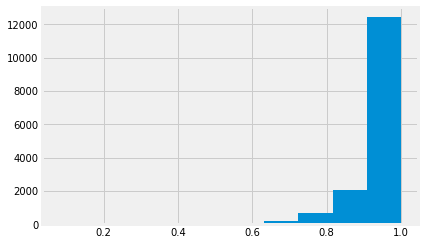

In [16]:
plt.hist(label_ratio['ratio'])

In [20]:
label_ratio.sort_values('ratio').head(10)

,id,ratio
11899,C278EDC82048,0.080599
1127,129497C3E0FC,0.084321
14968,F5EE08CB44B9,0.091804
9441,9B23715DFB32,0.101572
14874,F45B396E0A01,0.110754
11241,B7C17E1993BA,0.111391
1679,1C17A2B71357,0.111892
13077,D753B3C6BDDA,0.113933
6650,6D0552F0EF16,0.115081
7773,803FA7997692,0.120228


In [28]:
#10퍼센트에 미달하는 id의 데이터를 없애줍니다.
# train = train[(train.id != 'C278EDC82048') and (train.id != '129497C3E0FC') and (train.id != 'F5EE08CB44B9')]
train = train[train.id != 'C278EDC82048']
train = train[train.id != '129497C3E0FC']
train = train[train.id != 'F5EE08CB44B9']

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144278 entries, 0 to 144292
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  144278 non-null  object 
 1   discourse_id        144278 non-null  float64
 2   discourse_start     144278 non-null  float64
 3   discourse_end       144278 non-null  float64
 4   discourse_text      144278 non-null  object 
 5   discourse_type      144278 non-null  object 
 6   discourse_type_num  144278 non-null  object 
 7   predictionstring    144278 non-null  object 
 8   label               144278 non-null  int64  
 9   char_len            144278 non-null  int64  
 10  word_len            144278 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 13.2+ MB


In [30]:
#임시저장
train.to_csv('tmp', index = False)

#### 4. feature making/ correlation removing

numerical하게 correlation을 판단할 만한 변수가 적기 때문에 우선 피쳐를 한 개 추가해 보겠습니다.   
stop word의 갯수 피쳐인데, 'a','an','the'같이 의미가 없는 단어들을 stop word라고 칭한다고 합니다.

참조: https://www.kaggle.com/swaralipibose/highly-indetailed-eda-observing-relation-in-data#Concluding-Statement


In [33]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [34]:
#우선은 토크나이즈 시켜줍니다.
sentences=list(train['discourse_text'])
from nltk.tokenize import word_tokenize
tokenized=list(map(word_tokenize,tqdm(sentences)))

  0%|          | 0/144278 [00:00<?, ?it/s]

In [36]:
#spacy 라이브러리 사용
from spacy.lang.en.stop_words import STOP_WORDS as stop_words

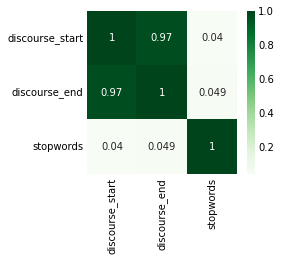

In [40]:
train_tmp = train[['discourse_start', 'discourse_end', 'stopwords']]
plt.figure(figsize=(3, 3))
sns.heatmap(train_tmp.corr(), annot=True, cmap='Greens')

start와 end의 상관관계는 대체로 문장 길이들이 비슷하다는 것을 나타낸다고 해석할 수 있을 것 같습니다.    
따라서 이전에 outlier에서 처리하지 않았던, 문장길이가 너무 긴 것이나 짧은 것도 따로 아웃라이어로 처리해주면 좋을 것 같습니다.   
stopwords와는 상관관계를 이루지 않으니 우선은 새로운 피쳐로 넣을 수 있을 것입니다.   
여러 모델에서 텍스트와 함께 이러한 피쳐들을 사용할 수 있습니다.

참조 https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/